In [1]:
# from openpiv import tools, pyprocess, validation, filters, scaling 

# import numpy as np
# import cv2
# import os
# import glob

# import matplotlib.pyplot as plt
# from matplotlib import colormaps
# from scipy.linalg import eigh
# from eofs.standard import Eof
# from scipy.fft import fft2, fftshift
# from scipy.optimize import curve_fit

# from PIL import Image
# from scipy.interpolate import RegularGridInterpolator
# from scipy.ndimage import gaussian_filter as smoo

#%run Eof_Functions.ipynb

from Eof_functions import *



In [2]:
# list the name of the files present in C:\Users\ratynski\Documents\Python_Projects\stratocu_waves-main\DATA\2022_09_06
# and store all the png files in a list

path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\2022_09_06\\'
os.chdir(path)
files = glob.glob('*.png')

for file in files:
    print(file)


image_0_2022_09_06_15_15_00Z.png
image_1_2022_09_06_15_45_00Z.png
image_2_2022_09_06_16_15_00Z.png
image_3_2022_09_06_16_45_00Z.png
image_4_2022_09_06_17_15_00Z.png
image_5_2022_09_06_17_45_00Z.png
image_6_2022_09_06_18_15_00Z.png
image_7_2022_09_06_18_45_00Z.png
image_8_2022_09_06_19_15_00Z.png
image_9_2022_09_06_19_45_00Z.png


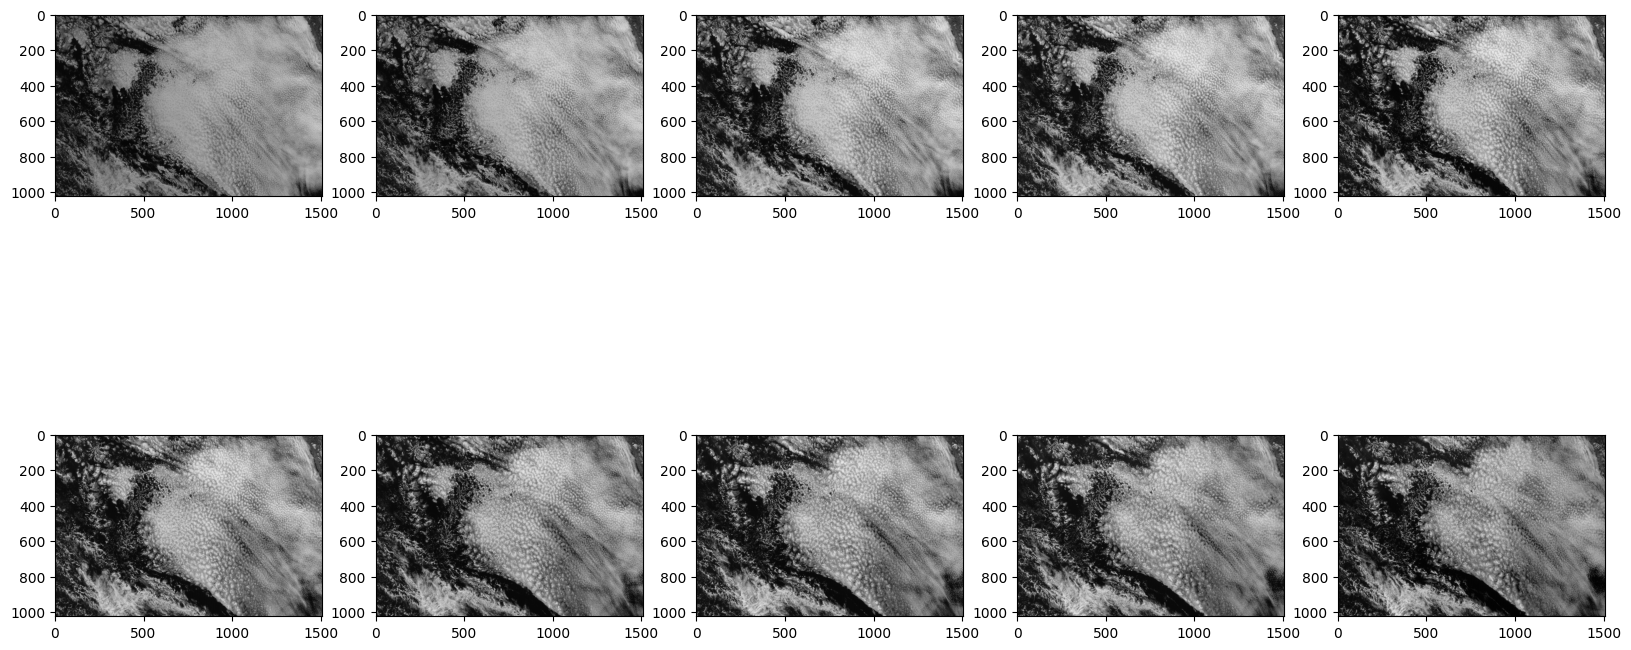

In [3]:
#for each image, create a frame_letter variable that will be used to store the imread image

frame_a = tools.imread(path + files[0])
frame_b = tools.imread(path + files[1])
frame_c = tools.imread(path + files[2])
frame_d = tools.imread(path + files[3])
frame_e = tools.imread(path + files[4])
frame_f = tools.imread(path + files[5])
frame_g = tools.imread(path + files[6])
frame_h = tools.imread(path + files[7])
frame_i = tools.imread(path + files[8])
frame_j = tools.imread(path + files[9])

# plot the images in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs[0,0].imshow(frame_a,cmap='gray')
axs[0,1].imshow(frame_b,cmap='gray')
axs[0,2].imshow(frame_c,cmap='gray')
axs[0,3].imshow(frame_d,cmap='gray')
axs[0,4].imshow(frame_e,cmap='gray')
axs[1,0].imshow(frame_f,cmap='gray')
axs[1,1].imshow(frame_g,cmap='gray')
axs[1,2].imshow(frame_h,cmap='gray')
axs[1,3].imshow(frame_i,cmap='gray')
axs[1,4].imshow(frame_j,cmap='gray')

frames = np.array([frame_a, frame_b, frame_c, frame_d, frame_e, frame_f, frame_g, frame_h, frame_i, frame_j])

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray, clim=[0,200])
ax[1].imshow(frame_b,cmap=plt.cm.gray, clim=[0,200])

In [ ]:
filtered_data=FFT_Analysis(frames,plot_option='no')

In [4]:
frames_data = frames.copy()
frames_index = [5,6]
threshold = 0.1


data = frames_data[frames_index,:,:].copy()
frame_a, frame_b = data[0], data[1]
frame_a_hp = frame_a.copy() - smoo(frame_a, 10)
frame_b_hp = frame_b.copy() - smoo(frame_b, 10)

winsize = 36 # pixels, interrogation window size in frame A
searchsize = 36  # pixels, search in image B big enough to contain credible velocity 
overlap = 18 # pixels, 50% overlap if half of winsize
dt = 1 # time interval between images, converts pixel displacement to velocity

# Use high-pass images as the PIV source frame_a_hp, frame_b_hp

u, v, sig2noise = pyprocess.extended_search_area_piv(  frame_a_hp.astype(np.int32), 
                                                    frame_b_hp.astype(np.int32), 
                                                    window_size=winsize, 
                                                    overlap=overlap, 
                                                    dt=dt, 
                                                    search_area_size=searchsize, 
                                                    sig2noise_method='peak2mean')
# Coordinates of velocity positions in image array
x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                search_area_size=searchsize, 
                                overlap=overlap )

mask = validation.global_std(u, v, std_threshold=3)
#replace outliers with NaNs
u[mask] = np.nan
v[mask] = np.nan

mask = validation.global_std(u, v, std_threshold=3)
#replace outliers with NaNs
u[mask] = np.nan
v[mask] = np.nan

u, v = filters.replace_outliers( u, v, mask,
                                method='localmean', 
                                max_iter=7, 
                                kernel_size=7)

x, y, u, v = tools.transform_coordinates(x, y, u, v)

divx = np.gradient(u)[1]
divy = -np.gradient(v)[0]
div = divx+divy

# Subtract the shifted array from the original, removing the last frame which has no subsequent frame
frames_data = frames_data[:-1] - frames_data[1:]

filtered_data=FFT_Analysis(frames_data,plot_option='no',plot_result='no')


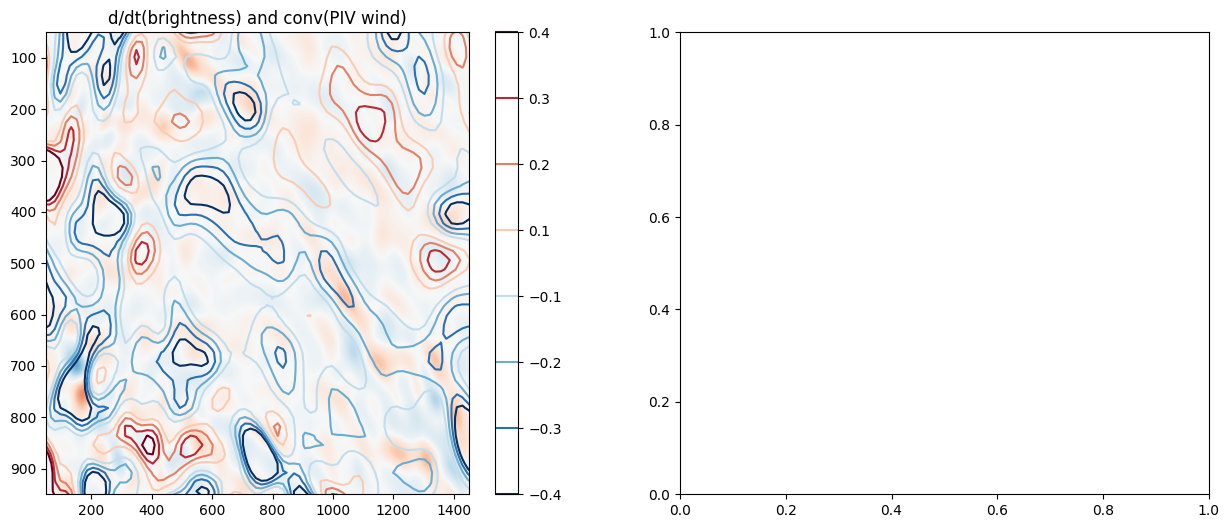

In [15]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjusting figsize to accommodate both plots

# First plot on ax1
mesh = ax1.pcolormesh(smoo(filtered_data[frames_index[0]], 20), cmap='RdBu_r')
ax1.set_title('d/dt(brightness) and conv(PIV wind)')
ax1.set_ylim(950, 50)
ax1.set_xlim(50, 1450)
#fig.colorbar(mesh, ax=ax1, orientation='vertical')
mesh.set_clim(-40, 40)  # Set color limits
smooth_con  = smoo(-div, 2)
contour_levels = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
cont = ax1.contour(x, y, np.flipud(smooth_con), levels=contour_levels, cmap='RdBu_r')
fig.colorbar(cont, ax=ax1, orientation='vertical')

# Prepare data for the second plot
# smooth_con = resize_matrix(smoo(-div, 2), filtered_data[frames_index[0]].shape)



# PCRegression(smoo(filtered_data[frames_index[0]], 20), np.flipud(smooth_con), plot_option='yes', ax=ax2)

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

# close_points_coordinates = Get_Candidates(filtered_data[frames_index[0]],np.flipud(smooth_con),threshold,plot_option='yes')
# Plot_Candidates(frames_data, frames_index, close_points_coordinates)


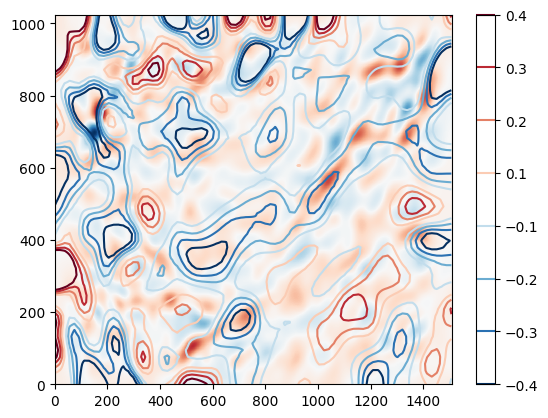

In [22]:
plt.figure()
smooth_con = resize_matrix(smoo(-div, 2), filtered_data[frames_index[0]].shape)
plt.pcolormesh(smoo(filtered_data[frames_index[0]], 20), cmap='RdBu_r')
#contour_levels = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
plt.contour(smooth_con, levels = contour_levels, cmap='RdBu_r')
#plt.contour(x, y, np.flipud(smooth_con), levels=contour_levels, cmap='RdBu_r')
plt.colorbar()
plt.show()

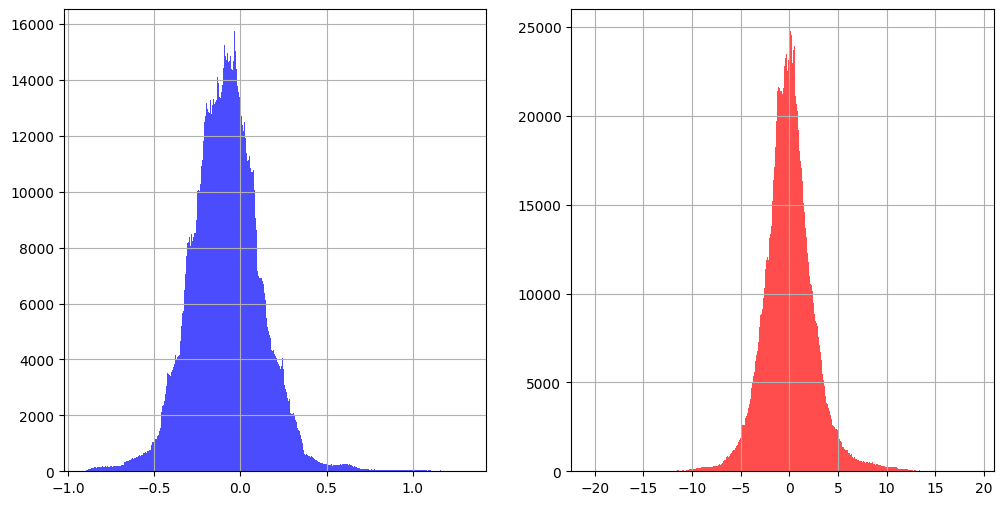

In [26]:
# Plotting the distribution of kl and c values 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(smooth_con.flatten(), bins=500, color='blue', alpha=0.7)
# axs[0].set_title("wavenumber cycles per pixel")
# axs[0].set_xlabel("wavenumber (cpm)")
# axs[0].set_ylabel("Frequency")
axs[0].grid(True)
axs[0].grid(True)

axs[1].hist(smoo(filtered_data[frames_index[0]], 20).flatten(), bins=500, color='red', alpha=0.7)
# axs[1].set_title("Phase Speed (Pixel per Frame)")
# axs[1].set_xlabel("Phase Speed (Pixel per Frame)")
# axs[1].set_ylabel("Frequency")
axs[1].grid(True)

(500.0, 1400.0)

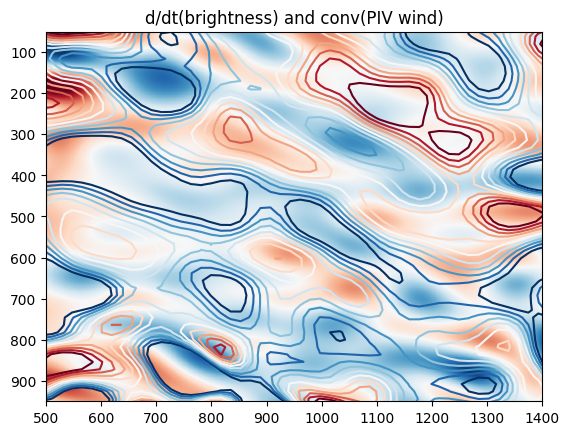

In [31]:
frames_data = frames.copy()
frames_index = [5,6]
threshold = 0.1


data = frames_data[frames_index,:,:].copy()
frame_a, frame_b = data[0], data[1]


# High pass the images to make sure the tracking is not of wave velocity itself
frame_a_hp = frame_a.copy() - smoo(frame_a, 10)
frame_b_hp = frame_b.copy() - smoo(frame_b, 10)

winsize = 36 # pixels, interrogation window size in frame A
searchsize = 36  # pixels, search in image B big enough to contain credible velocity 
overlap = 18 # pixels, 50% overlap if half of winsize
dt = 1 # time interval between images, converts pixel displacement to velocity

# Use high-pass images as the PIV source frame_a_hp, frame_b_hp

u, v, sig2noise = pyprocess.extended_search_area_piv(  frame_a_hp.astype(np.int32), 
                                                    frame_b_hp.astype(np.int32), 
                                                    window_size=winsize, 
                                                    overlap=overlap, 
                                                    dt=dt, 
                                                    search_area_size=searchsize, 
                                                    sig2noise_method='peak2mean')
# Coordinates of velocity positions in image array
x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                search_area_size=searchsize, 
                                overlap=overlap )

mask = validation.global_std(u, v, std_threshold=3)
#replace outliers with NaNs
u[mask] = np.nan
v[mask] = np.nan

mask = validation.global_std(u, v, std_threshold=3)
#replace outliers with NaNs
u[mask] = np.nan
v[mask] = np.nan

u, v = filters.replace_outliers( u, v, mask,
                                method='localmean', 
                                max_iter=7, 
                                kernel_size=7)

x, y, u, v = tools.transform_coordinates(x, y, u, v)

divx = np.gradient(u)[1]
divy = -np.gradient(v)[0]
div = divx+divy

# Fourier transform and shift to center and total wavenumber array kl
diff = frame_b-frame_a
diffhat = np.fft.fftshift(np.fft.fft2(diff))

# Wavenumbers 
kl = distance_from(diffhat, [diffhat.shape[0]/2, diffhat.shape[1]/2] )

mask = (  (kl>0) & (kl<=10) ) 

recon = np.fft.ifft2( np.fft.ifftshift( diffhat*mask ))

plt.pcolormesh(recon.real, cmap='RdBu_r')
plt.clim(-20,20); plt.title('d/dt(brightness) and conv(PIV wind)')

plt.contour(x,y, np.flipud(smoo(-div, 2)), levels=(-5+np.arange(11))/20., cmap='RdBu_r')
plt.ylim(950,50); plt.xlim(500,1400)  

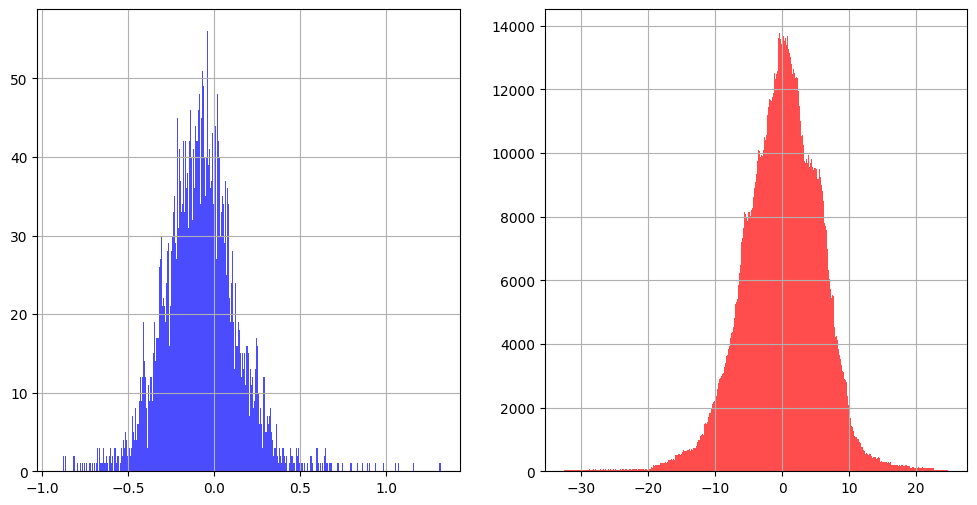

In [34]:
# Plotting the distribution of kl and c values 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(smoo(-div, 2).flatten(), bins=500, color='blue', alpha=0.7)
# axs[0].set_title("wavenumber cycles per pixel")
# axs[0].set_xlabel("wavenumber (cpm)")
# axs[0].set_ylabel("Frequency")
axs[0].grid(True)
axs[0].grid(True)

axs[1].hist(recon.real.flatten(), bins=500, color='red', alpha=0.7)
# axs[1].set_title("Phase Speed (Pixel per Frame)")
# axs[1].set_xlabel("Phase Speed (Pixel per Frame)")
# axs[1].set_ylabel("Frequency")
axs[1].grid(True)

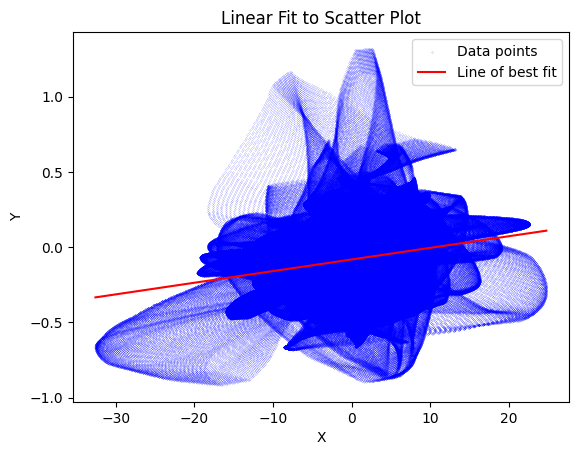

(0.007729849815323737, -0.08155479198811276, 0.046753838694187144)

In [46]:
# smoo(-div, 2).shape , resize_matrix(smoo(-div, 2),recon.real.shape).shape
# resize_matrix(smoo(-div, 2),recon.real.shape).shape

# PCRegression(recon.real,resize_matrix(smoo(-div, 2),recon.real.shape),plot_option='yes')

from re import X
from scipy.stats import linregress

x = recon.real.flatten()
y = resize_matrix(smoo(-div, 2),recon.real.shape).flatten()

# Perform a linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Prepare the line of best fit
line_x = np.linspace(min(x), max(x), 100)
line_y = slope * line_x + intercept

# Plot the data and the line of best fit
plt.scatter(x, y, color='blue', label='Data points',s=0.01)
plt.plot(line_x, line_y, 'r', label='Line of best fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Fit to Scatter Plot')
plt.legend()
plt.show()

# Output the parameters of the fit
(slope, intercept, r_value**2)  # Return the slope, intercept, and coefficient of determination (R-squared)

# Comment out the plotting to prevent automatic execution
# plt.show()



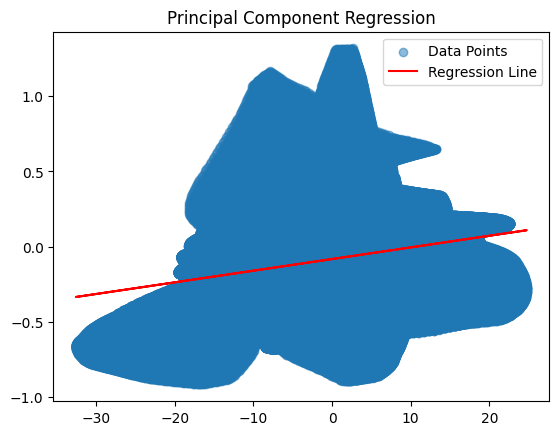

Variance explained by the first component: 0.9987833959540793


In [45]:
PCRegression(recon.real,resize_matrix(smoo(-div, 2),recon.real.shape),plot_option='yes')

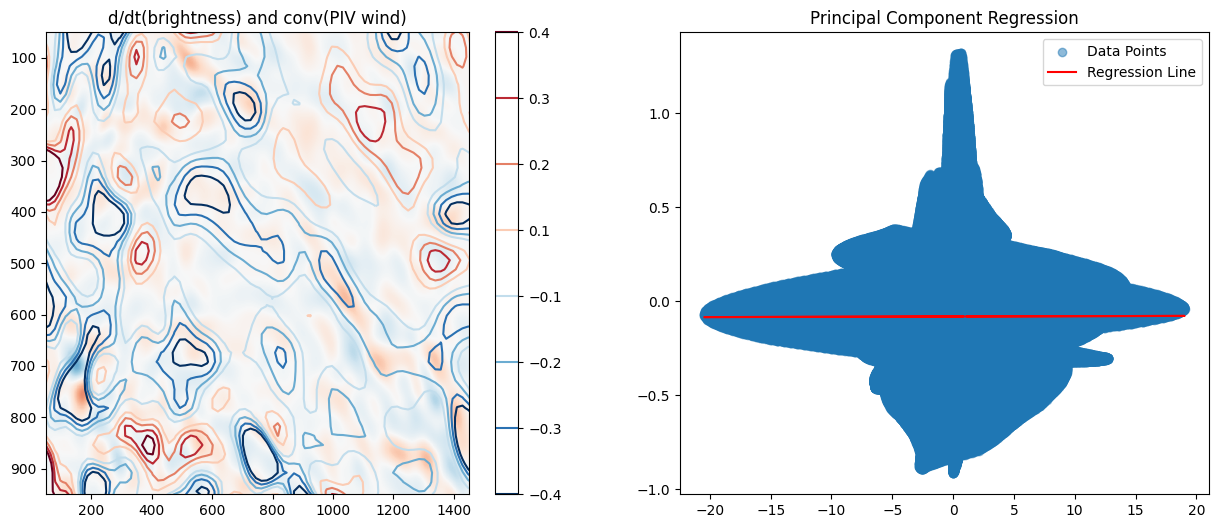

Variance explained by the first component: 0.9939599860780987


<Figure size 640x480 with 0 Axes>

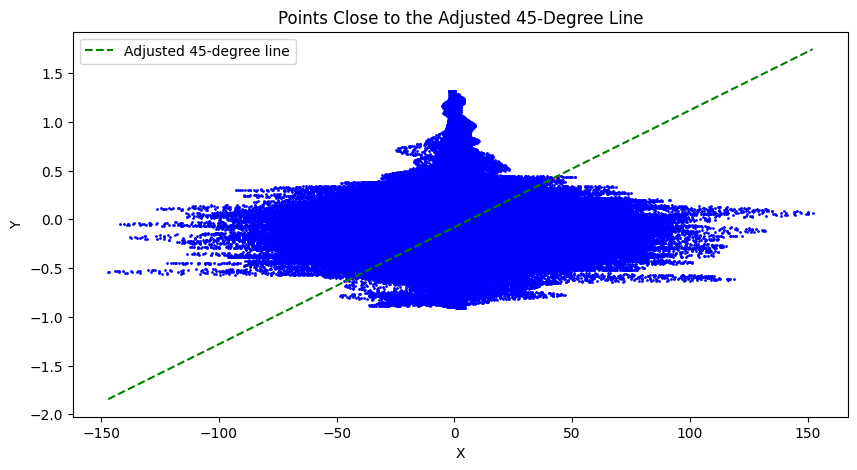

Percentage of points close to the line: 3.18%


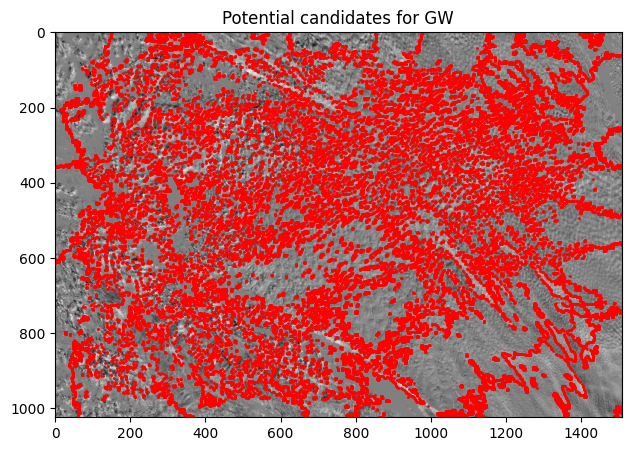

In [24]:
def Show_Contour_FFT(frames_data,frames_index=[0,1],threshold=0.1):
    data = frames_data[frames_index,:,:].copy()
    frame_a, frame_b = data[0], data[1]
    frame_a_hp = frame_a.copy() - smoo(frame_a, 10)
    frame_b_hp = frame_b.copy() - smoo(frame_b, 10)

    winsize = 36 # pixels, interrogation window size in frame A
    searchsize = 36  # pixels, search in image B big enough to contain credible velocity 
    overlap = 18 # pixels, 50% overlap if half of winsize
    dt = 1 # time interval between images, converts pixel displacement to velocity

    # Use high-pass images as the PIV source frame_a_hp, frame_b_hp

    u, v, sig2noise = pyprocess.extended_search_area_piv(  frame_a_hp.astype(np.int32), 
                                                        frame_b_hp.astype(np.int32), 
                                                        window_size=winsize, 
                                                        overlap=overlap, 
                                                        dt=dt, 
                                                        search_area_size=searchsize, 
                                                        sig2noise_method='peak2mean')
    # Coordinates of velocity positions in image array
    x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                    search_area_size=searchsize, 
                                    overlap=overlap )

    mask = validation.global_std(u, v, std_threshold=3)
    #replace outliers with NaNs
    u[mask] = np.nan
    v[mask] = np.nan

    mask = validation.global_std(u, v, std_threshold=3)
    #replace outliers with NaNs
    u[mask] = np.nan
    v[mask] = np.nan

    u, v = filters.replace_outliers( u, v, mask,
                                    method='localmean', 
                                    max_iter=7, 
                                    kernel_size=7)
    
    x, y, u, v = tools.transform_coordinates(x, y, u, v)

    divx = np.gradient(u)[1]
    divy = -np.gradient(v)[0]
    div = divx+divy

    # Subtract the shifted array from the original, removing the last frame which has no subsequent frame
    frames_data = frames_data[:-1] - frames_data[1:]

    filtered_data=FFT_Analysis(frames_data,plot_option='no',plot_result='no')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjusting figsize to accommodate both plots

    # First plot on ax1
    mesh = ax1.pcolormesh(smoo(filtered_data[frames_index[0]], 20), cmap='RdBu_r')
    ax1.set_title('d/dt(brightness) and conv(PIV wind)')
    ax1.set_ylim(950, 50)
    ax1.set_xlim(50, 1450)
    #fig.colorbar(mesh, ax=ax1, orientation='vertical')
    mesh.set_clim(-40, 40)  # Set color limits
    smooth_con  = smoo(-div, 2)
    contour_levels = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
    cont = ax1.contour(x, y, np.flipud(smooth_con), levels=contour_levels, cmap='RdBu_r')
    fig.colorbar(cont, ax=ax1, orientation='vertical')

    # Prepare data for the second plot
    smooth_con = resize_matrix(smoo(-div, 2), filtered_data[frames_index[0]].shape)
    #smooth_con = smoo(con, 2)
    
    PCRegression(smoo(filtered_data[frames_index[0]], 20), np.flipud(smooth_con), plot_option='yes', ax=ax2)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

    close_points_coordinates = Get_Candidates(filtered_data[frames_index[0]],np.flipud(smooth_con),threshold,plot_option='yes')
    Plot_Candidates(frames_data, frames_index, close_points_coordinates)
   

  
Show_Contour_FFT(frames,frames_index=[5,6],threshold=0.01)
    

In [ ]:
def Show_Contour_FFT_test(frames_data,frames_index=[0,1],threshold=0.01):
    data = frames_data[frames_index,:,:].copy()
    frame_a, frame_b = data[0], data[1]
    frame_a_hp = frame_a.copy() - smoo(frame_a, 10)
    frame_b_hp = frame_b.copy() - smoo(frame_b, 10)

    winsize = 36 # pixels, interrogation window size in frame A
    searchsize = 36  # pixels, search in image B big enough to contain credible velocity 
    overlap = 18 # pixels, 50% overlap if half of winsize
    dt = 1 # time interval between images, converts pixel displacement to velocity

    # Use high-pass images as the PIV source frame_a_hp, frame_b_hp

    u, v, sig2noise = pyprocess.extended_search_area_piv(  frame_a_hp.astype(np.int32), 
                                                        frame_b_hp.astype(np.int32), 
                                                        window_size=winsize, 
                                                        overlap=overlap, 
                                                        dt=dt, 
                                                        search_area_size=searchsize, 
                                                        sig2noise_method='peak2mean')
    # Coordinates of velocity positions in image array
    x, y = pyprocess.get_coordinates(image_size=frame_a.shape, 
                                    search_area_size=searchsize, 
                                    overlap=overlap )

    mask = validation.global_std(u, v, std_threshold=3)
    #replace outliers with NaNs
    u[mask] = np.nan
    v[mask] = np.nan

    mask = validation.global_std(u, v, std_threshold=3)
    #replace outliers with NaNs
    u[mask] = np.nan
    v[mask] = np.nan

    u, v = filters.replace_outliers( u, v, mask,
                                    method='localmean', 
                                    max_iter=7, 
                                    kernel_size=7)
    
    x, y, u, v = tools.transform_coordinates(x, y, u, v)

    divx = np.gradient(u)[1]
    divy = -np.gradient(v)[0]
    div = divx+divy

    # Subtract the shifted array from the original, removing the last frame which has no subsequent frame
    frames_data = frames_data[:-1] - frames_data[1:]

    filtered_data=FFT_Analysis(frames_data,plot_option='no',plot_result='no')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjusting figsize to accommodate both plots

    # First plot on ax1
    mesh = ax1.pcolormesh(smoo(filtered_data[frames_index[0]], 5), cmap='RdBu_r')
    ax1.set_title('d/dt(brightness) and conv(PIV wind)')
    ax1.set_ylim(950, 50)
    ax1.set_xlim(50, 1450)
    #fig.colorbar(mesh, ax=ax1, orientation='vertical')
    mesh.set_clim(-40, 40)  # Set color limits
    smooth_con  = smoo(-div, 2)
    contour_levels = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
    cont = ax1.contour(x, y, np.flipud(smooth_con), levels=contour_levels, cmap='RdBu_r')
    fig.colorbar(cont, ax=ax1, orientation='vertical')

    # Prepare data for the second plot
    con = resize_matrix(div, filtered_data[frames_index[0]].shape)
    smooth_con = smoo(con, 2)


    close_points_coordinates = Get_Candidates(filtered_data[frames_index[0]],np.flipud(smooth_con),threshold,plot_option='no')

    mesh = ax2.pcolormesh(smoo(filtered_data[frames_index[0]], 5), cmap='RdBu_r')
    ax2.set_title('d/dt(brightness) and conv(PIV wind)')
    ax2.set_ylim(950, 50)
    ax2.set_xlim(50, 1450)
    #fig.colorbar(mesh, ax=ax1, orientation='vertical')
    mesh.set_clim(-40, 40)  # Set color limits
    smooth_con  = smoo(-div, 2)
    contour_levels = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]
    cont = ax2.contour(x, y, np.flipud(smooth_con), levels=contour_levels, cmap='RdBu_r')
    fig.colorbar(cont, ax=ax2, orientation='vertical')
    ax2.scatter([p[1] for p in close_points_coordinates], [p[0] for p in close_points_coordinates], s=1, color='red')
    plt.tight_layout()  # Adjust layout to prevent overlap

    plt.show()
    print(len(close_points_coordinates))


  
Show_Contour_FFT_test(frames,frames_index=[0,1])
    

In [ ]:
# plot two figures
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(filtered_data[0],cmap='RdBu_r', clim=[-50,50])
ax[1].imshow(smoo(filtered_data[0],10),cmap='RdBu_r', clim=[-50,50])


In [ ]:
#open frames from the Wrap_Test folder and remove the white borders
path = 'C:\\Users\\ratynski\\Documents\\Python_Projects\\stratocu_waves-main\\DATA\\Wrap_Test\\'
os.chdir(path)
# Only keep files with the word "frame" in the name
files = [f for f in os.listdir() if 'image' in f]

#for i in range(len(files)):
#    path_to_image = path + files[i]
#    crop_to_central_data(path_to_image,i)
    #print(f"Image {i} cropped successfully.")



In [ ]:
#files = [f for f in os.listdir() if 'image' in f]

frame_a = tools.imread(path + files[0])
frame_b = tools.imread(path + files[1])
frame_c = tools.imread(path + files[2])
frame_d = tools.imread(path + files[3])
frame_e = tools.imread(path + files[4])
frame_f = tools.imread(path + files[5])
frame_g = tools.imread(path + files[6])
frame_h = tools.imread(path + files[7])
frame_i = tools.imread(path + files[8])
frame_j = tools.imread(path + files[9])

# plot the images in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs[0,0].imshow(frame_a,cmap='gray')
axs[0,1].imshow(frame_b,cmap='gray')
axs[0,2].imshow(frame_c,cmap='gray')
axs[0,3].imshow(frame_d,cmap='gray')
axs[0,4].imshow(frame_e,cmap='gray')
axs[1,0].imshow(frame_f,cmap='gray')
axs[1,1].imshow(frame_g,cmap='gray')
axs[1,2].imshow(frame_h,cmap='gray')
axs[1,3].imshow(frame_i,cmap='gray')
axs[1,4].imshow(frame_j,cmap='gray')